In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC


from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import precision_recall_curve, auc

import warnings
warnings.filterwarnings("ignore")

In [2]:
train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("validate.csv")
test_df = pd.read_csv("test.csv")

In [3]:
train_df = train_df.dropna(subset=["clean_text", "label"])
val_df   = val_df.dropna(subset=["clean_text", "label"])
test_df  = test_df.dropna(subset=["clean_text", "label"])

In [4]:
X_train = train_df["clean_text"]
y_train = train_df["label"]

X_val = val_df["clean_text"]
y_val = val_df["label"]

X_test = test_df["clean_text"]
y_test = test_df["label"]

# Model 1- Multionomial Naive Bayes

In [5]:
mnb_model = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=5000,
        ngram_range=(1,2),   # captures phrases like "free offer"
        stop_words="english"
    )),
    ("model", MultinomialNB())
])

mnb_model.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('model', MultinomialNB())])

In [6]:
val_pred = mnb_model.predict(X_val)

print("Validation Accuracy:", accuracy_score(y_val, val_pred))
print(classification_report(y_val, val_pred))


Validation Accuracy: 0.9677033492822966
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       724
           1       1.00      0.76      0.86       112

    accuracy                           0.97       836
   macro avg       0.98      0.88      0.92       836
weighted avg       0.97      0.97      0.97       836



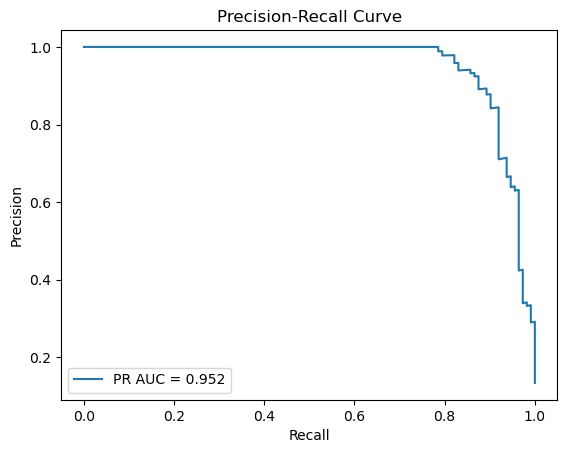

In [7]:
probs = mnb_model.predict_proba(X_val)[:, 1]

precision, recall, _ = precision_recall_curve(y_val, probs)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# Hyperparameter Tuning

In [8]:
param_grid = {
    "model__alpha": [0.01, 0.1, 0.5, 1.0, 2.0],
    "model__fit_prior": [True, False]
}

grid_search = GridSearchCV(mnb_model, param_grid, scoring = "f1", cv=5)
grid_search.fit(X_train, y_train)

best_mnb_model = grid_search.best_estimator_
best_mnb_model.fit(X_train, y_train)

val_pred = best_mnb_model.predict(X_val)

print("Best Parameters:")
print(grid_search.best_params_)

print("\nBest Score:", grid_search.best_score_)

Best Parameters:
{'model__alpha': 0.1, 'model__fit_prior': True}

Best Score: 0.9253857380649558


In [9]:
print("Validation Accuracy:", accuracy_score(y_val, val_pred))
print(classification_report(y_val, val_pred))

Validation Accuracy: 0.9772727272727273
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       724
           1       0.98      0.85      0.91       112

    accuracy                           0.98       836
   macro avg       0.98      0.92      0.95       836
weighted avg       0.98      0.98      0.98       836



# Final Test Evaluation

In [10]:
test_pred = best_mnb_model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, test_pred))
print(classification_report(y_test, test_pred))

Test Accuracy: 0.9796163069544365
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       722
           1       0.94      0.90      0.92       112

    accuracy                           0.98       834
   macro avg       0.96      0.95      0.96       834
weighted avg       0.98      0.98      0.98       834



# Model 2 - Logistic Regression

In [11]:
log_model = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=5000,
        ngram_range=(1,2),
        stop_words="english"
    )),
    ("model", LogisticRegression(max_iter=1000))
])

log_model.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('model', LogisticRegression(max_iter=1000))])

In [12]:
val_pred = log_model.predict(X_val)

print("Validation Accuracy:", accuracy_score(y_val, val_pred))
print(classification_report(y_val, val_pred))

Validation Accuracy: 0.9593301435406698
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       724
           1       1.00      0.70      0.82       112

    accuracy                           0.96       836
   macro avg       0.98      0.85      0.90       836
weighted avg       0.96      0.96      0.96       836



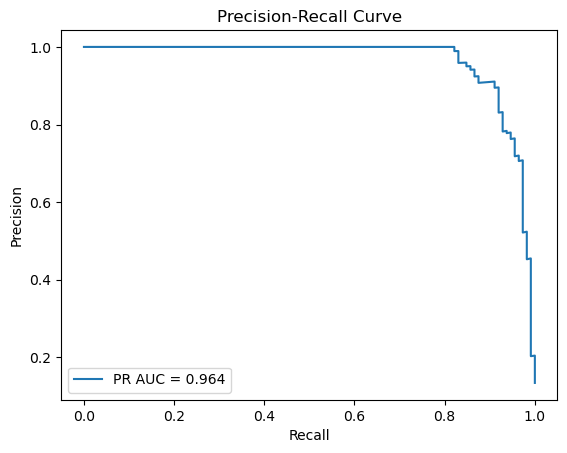

In [13]:
probs = log_model.predict_proba(X_val)[:, 1]

precision, recall, _ = precision_recall_curve(y_val, probs)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# Hyperparameter Tuning

In [14]:
param_grid = {
    "model__C": [0.1, 1, 5, 10],
    "model__penalty": ["l2"],
    "model__solver": ["lbfgs"]
}

grid_search = GridSearchCV(log_model, param_grid, scoring = "f1", cv=5)
grid_search.fit(X_train, y_train)

best_log_model = grid_search.best_estimator_
best_log_model.fit(X_train, y_train)

val_pred = best_log_model.predict(X_val)

print("Best Parameters:")
print(grid_search.best_params_)

print("\nBest Score:", grid_search.best_score_)

Best Parameters:
{'model__C': 10, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}

Best Score: 0.9052875644836048


In [15]:
print("Validation Accuracy:", accuracy_score(y_val, val_pred))
print(classification_report(y_val, val_pred))

Validation Accuracy: 0.9832535885167464
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       724
           1       1.00      0.88      0.93       112

    accuracy                           0.98       836
   macro avg       0.99      0.94      0.96       836
weighted avg       0.98      0.98      0.98       836



# Final Test Evaluation

In [16]:
test_pred = best_log_model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, test_pred))
print(classification_report(y_test, test_pred))

Test Accuracy: 0.9772182254196643
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       722
           1       0.91      0.92      0.92       112

    accuracy                           0.98       834
   macro avg       0.95      0.95      0.95       834
weighted avg       0.98      0.98      0.98       834



# Model 3 - Linear SVM (LinearSVC)

In [17]:
svm_model = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=5000,
        ngram_range=(1,2),
        stop_words="english"
    )),
    ("model", LinearSVC())
])

svm_model.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('model', LinearSVC())])

In [18]:
val_pred = svm_model.predict(X_val)

print("Validation Accuracy:", accuracy_score(y_val, val_pred))
print(classification_report(y_val, val_pred))

Validation Accuracy: 0.9856459330143541
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       724
           1       1.00      0.89      0.94       112

    accuracy                           0.99       836
   macro avg       0.99      0.95      0.97       836
weighted avg       0.99      0.99      0.99       836



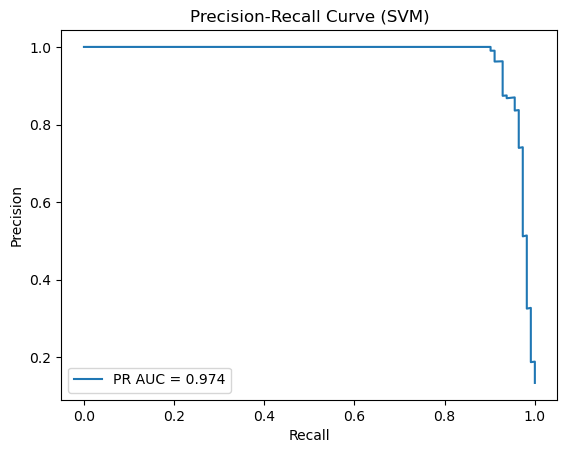

In [19]:
scores = svm_model.decision_function(X_val)

precision, recall, _ = precision_recall_curve(y_val, scores)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (SVM)")
plt.legend()
plt.show()

# Hyperparameter Tuning

In [20]:
param_grid = {
    "model__C": [0.1, 1, 5, 10]}


grid_search = GridSearchCV(svm_model, param_grid, scoring = "f1", cv=5)
grid_search.fit(X_train, y_train)

best_svc_model = grid_search.best_estimator_
best_svc_model.fit(X_train, y_train)

val_pred = best_svc_model.predict(X_val)

print("Best Parameters:")
print(grid_search.best_params_)

print("\nBest Score:", grid_search.best_score_)

Best Parameters:
{'model__C': 1}

Best Score: 0.9196321632464339


In [21]:
print("Validation Accuracy:", accuracy_score(y_val, val_pred))
print(classification_report(y_val, val_pred))

Validation Accuracy: 0.9856459330143541
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       724
           1       1.00      0.89      0.94       112

    accuracy                           0.99       836
   macro avg       0.99      0.95      0.97       836
weighted avg       0.99      0.99      0.99       836



# Final Test Evaluation

In [22]:
test_pred = best_svc_model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, test_pred))
print(classification_report(y_test, test_pred))

Test Accuracy: 0.9832134292565947
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       722
           1       0.93      0.95      0.94       112

    accuracy                           0.98       834
   macro avg       0.96      0.97      0.96       834
weighted avg       0.98      0.98      0.98       834



# Comparing all three models on the Test Data

In [23]:
def evaluate_spam_model(model, X_test, y_test):
    preds = model.predict(X_test)

    return {
        "Precision": precision_score(y_test, preds),
        "Recall": recall_score(y_test, preds),
        "F1": f1_score(y_test, preds),
        "CM": confusion_matrix(y_test, preds)
    }


In [24]:
mnb_metrics = evaluate_spam_model(best_mnb_model, X_test, y_test)
lr_metrics  = evaluate_spam_model(best_log_model, X_test, y_test)
svm_metrics = evaluate_spam_model(best_svc_model, X_test, y_test)


In [25]:
print("\n📊 SPAM MODEL COMPARISON")
print("="*55)
print(f"{'Metric':<12} {'Naive Bayes':<15} {'Logistic Reg':<15} {'Linear SVM':<15}")
print("-"*55)

print(f"{'Precision':<12} {mnb_metrics['Precision']:<15.3f} {lr_metrics['Precision']:<15.3f} {svm_metrics['Precision']:<15.3f}")
print(f"{'Recall':<12} {mnb_metrics['Recall']:<15.3f} {lr_metrics['Recall']:<15.3f} {svm_metrics['Recall']:<15.3f}")
print(f"{'F1 Score':<12} {mnb_metrics['F1']:<15.3f} {lr_metrics['F1']:<15.3f} {svm_metrics['F1']:<15.3f}")



📊 SPAM MODEL COMPARISON
Metric       Naive Bayes     Logistic Reg    Linear SVM     
-------------------------------------------------------
Precision    0.944           0.912           0.930          
Recall       0.902           0.920           0.946          
F1 Score     0.922           0.916           0.938          


In [26]:
print("\nConfusion Matrices (TN FP | FN TP)\n")

print(f"Naive Bayes     : {mnb_metrics['CM'].ravel()}")
print(f"Logistic Reg    : {lr_metrics['CM'].ravel()}")
print(f"Linear SVM      : {svm_metrics['CM'].ravel()}")



Confusion Matrices (TN FP | FN TP)

Naive Bayes     : [716   6  11 101]
Logistic Reg    : [712  10   9 103]
Linear SVM      : [714   8   6 106]
